Load the dataset


Module Imports 

In [4]:
# Importing the necessary librarires for the model
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments,AutoConfig,TrainerCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold,StratifiedGroupKFold
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay,precision_recall_fscore_support

Checking if the dataset is loading properly or not 

In [2]:
'''
In this part the data is being loaded from the csv file. And it is saved in a dataframe object. 
some general statistics of the dataset is being checked and some rows of the dataset is printed to check 
if the correct dataset was loaded or not.
'''

df=pd.read_csv("combined_dataset.csv")
length=len(df)
classes_used=df["Class"].unique()
print("The column headers are ",df.columns)
print("The length of the dataset is ",length)
print("The distinct abstract classes are ",df['Class'].unique())
#print(dataset.head())

The column headers are  Index(['Unnamed: 0', 'Index', 'Abstract', 'Class'], dtype='object')
The length of the dataset is  2792
The distinct abstract classes are  ['Astronomy' 'Psychology' 'Sociology']


In [3]:
'''
The final dataset "combined_dataset.csv" was cleaned and formatted before loading it here. But cleaning the dataset again 
with dataframe so that there is no discrepancy in the tokenization phase. Rows with empty abstracts are dropped. 
Duplicates are dropped, and making sure that all the abstracts are string. All of this is done with functions from dataframe object.  
'''


df = df.dropna(subset=['Abstract'])  # Dropping rows that has no abstracts
df = df[df['Abstract'].apply(lambda x: isinstance(x, str))]#Making sure abstract is string
df=df.drop_duplicates()#Drop the duplicate values 

Class
Sociology     957
Psychology    934
Astronomy     900
Name: count, dtype: int64


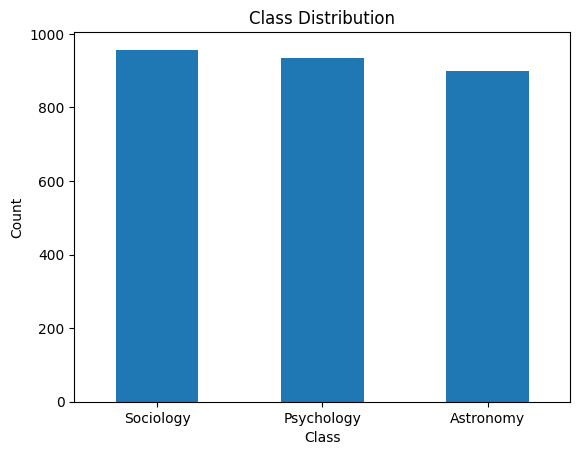

In [4]:
'''
Checking if the dataset is balanced or not. 
Astronomy is easier to predict because of the scientific terms used 
that's why keeping it to lowest to avoid bias in model prediction.
The class distribution is plotted to show the numbers of abstracts for each class 
'''

class_counts=df["Class"].value_counts()
print(class_counts)
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.show()

In [5]:
'''
Converting the field names to integer for tokenization process later on. In the tokenization process 
it can be done by tokenizer from hugging face transformers library as well . But i am doing it here with dataframe to keep 
track of the id's of the labels. In case if i need to check if the label is right or not.

'''
label_map = {'Astronomy': 0, 'Psychology': 1, 'Sociology': 2}
df['label'] = df['Class'].map(label_map)
print(df["label"].unique())#checking if the mapping is done correctly or not 
print(df["Class"][0])
print(df["label"][0])



[0 1 2]
Astronomy
0


label
2    957
1    934
0    900
Name: count, dtype: int64


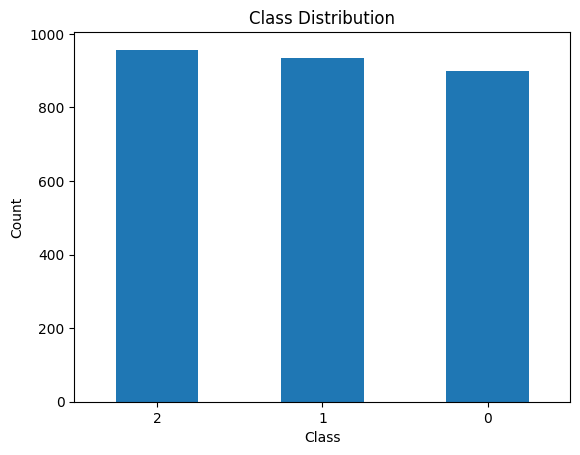

In [6]:
#Plotting the class distribution again to ensure label mapping is done correctly.
label_counts=df["label"].value_counts()
print(label_counts)
label_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.show()

In [7]:
'''
Converting the dataframe to a huggin face dataset object. The dataset object serves same features as dataframe 
but it is faster when mapping the tokenization and works with dataloaders . That's why converting it to a dataset object
'''

train_dataset = Dataset.from_pandas(df)
list(train_dataset)[1]#Printing a sample to check if the dataset is converted properyl or not


{'Unnamed: 0': 1,
 'Index': 2.0,
 'Abstract': 'We present a detailed systematics for comparing warped brane inflation with\nthe observations, incorporating the effects of both moduli stabilization and\nultraviolet bulk physics. We explicitly construct an example of the inflaton\npotential governing the motion of a mobile D3 brane in the entire warped\ndeformed conifold. This allows us to precisely identify the corresponding\nscales of the cosmic microwave background. The effects due to bulk fluxes or\nlocalized sources are parametrized using gauge/string duality. We next perform\nsome sample scannings to explore the parameter space of the complete potential,\nand first demonstrate that without the bulk effects there can be large\ndegenerate sets of parameters with observationally consistent predictions. When\nthe bulk perturbations are included, however, the observational predictions are\ngenerally spoiled. For them to remain consistent, the magnitudes of the bulk\neffects need to be h

In [8]:
'''
In this part of the code, the formatted dataset is tokenized with Distillbert tokenizer. which is a pretrained tokeizer 
for distilbert tokenized. The labels were converted to integers with the help of dataframe before. Therefore the 
abstracts are converted into integers here. That's a very brief description. 

The tokenizer used for this project is the pretrained distilbert based uncased tokenizer from hugging face. The uncased part indicates that all texts will be turned into lower case during the tokenization process.
 Then the words are compared with the vocabulary of wordpiece and they are given token ID’s. In case of unknown words it assigns the token [UNK]. The texts are truncated if they exceed the model’s maximum sequence length. Which is 512 for Bert.
   For this project all the sequences have a length of 512. For sequences that are shorter than 512 there is a padding that make the all the sequences of the same length. An attension mask is generated that distinguish actual tokens from padding tokens.  
   The tokenized data is returned as pytorch tensors as pyTorch library is used to train the model. The tokenization is applied to all abstracts using the map function from the dataset module. 
   Finally the whole dataset was converted into torch format with columns [input_ids],[attention_mask],[label]. The first two columns are default columns that distilBert model expects. 
   The label column is the feature column. All the columns are in the form of PyTorch tensors.
'''
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')#tokenizer from hugging face transformer module. which is a pretrained tokenizer

def tokenize_function(examples):
    # As mentioned above, this function is going to tokenize the abstracts only. For the abstracts texts the function is going to create input ids and attention mask for the abstract text.
    tokenized = tokenizer(
        examples['Abstract'],#Taking the abstract columns only, ignoring others
        padding='max_length',# 512 for bert. all sequences will have length of 512
        truncation=True, # If text exceed 512 shorten it 
        max_length=512,# The max sequence lenght the model can take as input
        return_tensors='pt'  # Return the outputs as PyTorch tensors directly
    )
    
    return tokenized  # Returns both input_ids and attention_mask

#Dataset object from the hugging face library maps each rows to a tokenized form. Specifically the abatract column only
train_dataset = train_dataset.map(tokenize_function, batched=True)
# Abstract column still remains in the train_dataset and contains strings or text. That caused error in the next line. Bye bye abstract column
train_dataset = train_dataset.remove_columns(['Abstract'])

# Setting the format for torch 
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# printing a sample from the tokenized dataset
print("Tokenized dataset sample:", train_dataset[0])

Map: 100%|██████████| 2791/2791 [00:07<00:00, 394.84 examples/s]

Tokenized dataset sample: {'label': tensor(0), 'input_ids': tensor([  101,  7987,  6633,  4757,  6494,  7317,  5575, 15760,  1997, 26383,
         2015,  2076,  4517,  9597,  2503,  9742, 17227,  5396,  2003, 10847,
         1999,  1996,  3259,  1012,  2005,  2008,  1010,  1037,  2047,  2944,
         1997, 13502,  2003,  2764,  1010,  2073,  4517,  2749, 11506, 16371,
        14321,  5644,  2004,  5391,  2291,  1999, 18642,  2006,  2784,  3295,
         2503,  9233,  2732,  1012,  1037, 26572, 13181, 24330,  2944,  1997,
         3340,  2012,  5950,  1002,  1050,  1027,  1017,  1002,  2007,  7939,
        24279,  7356,  2013,  2317, 11229,  2000, 20393,  2732,  2003,  2109,
         1012,  7987,  6633,  4757,  6494,  7317,  5575,  5337,  2964,  1998,
        16268,  2024,  2092,  7718,  2006,  5839,  6388,  2592,  2005, 17501,
         1997, 20843,  2015,  1997,  2422, 23767,  1999,  3011,  1012,  2057,
         2424,  1996,  2206,  1012,  1006,  1015,  1007,  1999, 20393,  3340,
    

In [ ]:
'''
This is a class that is going to keep track of all the losses over all train epochs. It is 
inheriting the trainer class and acceses the loss attribute that is calculated and logged by the trainer class
This is being done to visualize the models learning performance. 
 
'''

class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.losses = []  # List to store loss values
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Storing the logged loss values in the output 
        if 'loss' in logs:
            self.losses.append(logs['loss'])

    def get_losses(self):
        return self.losses

Finally the training time has come 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 1/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_40486/3954821614.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  3%|▎         | 21/837 [00:48<34:58,  2.57s/it]

{'loss': 0.9836, 'grad_norm': 3.6507720947265625, 'learning_rate': 1.9498207885304662e-05, 'epoch': 0.08}


  5%|▌         | 42/837 [01:28<22:52,  1.73s/it]

{'loss': 0.6013, 'grad_norm': 1.8786625862121582, 'learning_rate': 1.899641577060932e-05, 'epoch': 0.15}


  8%|▊         | 63/837 [02:01<20:28,  1.59s/it]

{'loss': 0.3713, 'grad_norm': 3.9413139820098877, 'learning_rate': 1.849462365591398e-05, 'epoch': 0.23}


 10%|█         | 84/837 [02:34<19:30,  1.55s/it]

{'loss': 0.2341, 'grad_norm': 6.2451581954956055, 'learning_rate': 1.799283154121864e-05, 'epoch': 0.3}


 13%|█▎        | 105/837 [03:07<19:17,  1.58s/it]

{'loss': 0.3198, 'grad_norm': 3.3907084465026855, 'learning_rate': 1.74910394265233e-05, 'epoch': 0.38}


 15%|█▌        | 126/837 [03:40<18:45,  1.58s/it]

{'loss': 0.2381, 'grad_norm': 0.4582228660583496, 'learning_rate': 1.6989247311827958e-05, 'epoch': 0.45}


 18%|█▊        | 147/837 [04:14<18:11,  1.58s/it]

{'loss': 0.2314, 'grad_norm': 10.10013484954834, 'learning_rate': 1.648745519713262e-05, 'epoch': 0.53}


 20%|██        | 168/837 [04:47<17:38,  1.58s/it]

{'loss': 0.2818, 'grad_norm': 9.179707527160645, 'learning_rate': 1.5985663082437275e-05, 'epoch': 0.6}


 23%|██▎       | 189/837 [05:19<16:41,  1.55s/it]

{'loss': 0.1911, 'grad_norm': 0.5762068033218384, 'learning_rate': 1.5483870967741936e-05, 'epoch': 0.68}


 25%|██▌       | 210/837 [05:53<17:56,  1.72s/it]

{'loss': 0.1246, 'grad_norm': 4.819074630737305, 'learning_rate': 1.4982078853046595e-05, 'epoch': 0.75}


 28%|██▊       | 231/837 [06:28<15:59,  1.58s/it]

{'loss': 0.2892, 'grad_norm': 23.14871597290039, 'learning_rate': 1.4480286738351255e-05, 'epoch': 0.83}


 30%|███       | 252/837 [07:00<14:30,  1.49s/it]

{'loss': 0.2193, 'grad_norm': 22.370296478271484, 'learning_rate': 1.3978494623655916e-05, 'epoch': 0.9}


 33%|███▎      | 273/837 [07:31<14:00,  1.49s/it]

{'loss': 0.1387, 'grad_norm': 3.3013315200805664, 'learning_rate': 1.3476702508960575e-05, 'epoch': 0.98}


                                                 
 33%|███▎      | 279/837 [08:11<13:58,  1.50s/it]

{'eval_loss': 0.24033242464065552, 'eval_runtime': 30.7594, 'eval_samples_per_second': 18.173, 'eval_steps_per_second': 2.276, 'epoch': 1.0}


 35%|███▌      | 294/837 [08:35<14:09,  1.56s/it]  

{'loss': 0.1746, 'grad_norm': 14.123255729675293, 'learning_rate': 1.2974910394265235e-05, 'epoch': 1.05}


 38%|███▊      | 315/837 [09:07<13:01,  1.50s/it]

{'loss': 0.0977, 'grad_norm': 0.8427460193634033, 'learning_rate': 1.2473118279569894e-05, 'epoch': 1.13}


 40%|████      | 336/837 [09:38<12:28,  1.49s/it]

{'loss': 0.1017, 'grad_norm': 0.1474449783563614, 'learning_rate': 1.1971326164874553e-05, 'epoch': 1.2}


 43%|████▎     | 357/837 [10:09<11:51,  1.48s/it]

{'loss': 0.1621, 'grad_norm': 14.059783935546875, 'learning_rate': 1.1469534050179212e-05, 'epoch': 1.28}


 45%|████▌     | 378/837 [10:41<11:21,  1.49s/it]

{'loss': 0.1424, 'grad_norm': 0.0858842059969902, 'learning_rate': 1.096774193548387e-05, 'epoch': 1.35}


 48%|████▊     | 399/837 [11:12<10:49,  1.48s/it]

{'loss': 0.1242, 'grad_norm': 0.5201699733734131, 'learning_rate': 1.0465949820788533e-05, 'epoch': 1.43}


 50%|█████     | 420/837 [11:44<11:08,  1.60s/it]

{'loss': 0.195, 'grad_norm': 2.041754722595215, 'learning_rate': 9.96415770609319e-06, 'epoch': 1.51}


 53%|█████▎    | 441/837 [12:19<10:26,  1.58s/it]

{'loss': 0.1333, 'grad_norm': 0.08283799886703491, 'learning_rate': 9.46236559139785e-06, 'epoch': 1.58}


 55%|█████▌    | 462/837 [12:51<09:20,  1.49s/it]

{'loss': 0.1149, 'grad_norm': 0.16428662836551666, 'learning_rate': 8.96057347670251e-06, 'epoch': 1.66}


 58%|█████▊    | 483/837 [13:22<08:46,  1.49s/it]

{'loss': 0.2173, 'grad_norm': 0.3080802261829376, 'learning_rate': 8.45878136200717e-06, 'epoch': 1.73}


 60%|██████    | 504/837 [13:53<08:13,  1.48s/it]

{'loss': 0.2005, 'grad_norm': 0.12341631203889847, 'learning_rate': 7.956989247311828e-06, 'epoch': 1.81}


 63%|██████▎   | 525/837 [14:25<07:42,  1.48s/it]

{'loss': 0.054, 'grad_norm': 0.21789300441741943, 'learning_rate': 7.455197132616489e-06, 'epoch': 1.88}


 65%|██████▌   | 546/837 [14:56<07:13,  1.49s/it]

{'loss': 0.0649, 'grad_norm': 0.09749850630760193, 'learning_rate': 6.9534050179211476e-06, 'epoch': 1.96}


                                                 
 67%|██████▋   | 558/837 [15:47<07:52,  1.69s/it]

{'eval_loss': 0.250365674495697, 'eval_runtime': 31.4608, 'eval_samples_per_second': 17.768, 'eval_steps_per_second': 2.225, 'epoch': 2.0}


 68%|██████▊   | 567/837 [16:02<09:21,  2.08s/it]

{'loss': 0.1461, 'grad_norm': 0.659947395324707, 'learning_rate': 6.451612903225806e-06, 'epoch': 2.03}


 70%|███████   | 588/837 [16:34<06:18,  1.52s/it]

{'loss': 0.1648, 'grad_norm': 0.11518650501966476, 'learning_rate': 5.949820788530466e-06, 'epoch': 2.11}


 73%|███████▎  | 609/837 [17:06<05:42,  1.50s/it]

{'loss': 0.0553, 'grad_norm': 0.1599055826663971, 'learning_rate': 5.4480286738351265e-06, 'epoch': 2.18}


 75%|███████▌  | 630/837 [17:37<05:11,  1.50s/it]

{'loss': 0.0682, 'grad_norm': 0.2130490392446518, 'learning_rate': 4.946236559139785e-06, 'epoch': 2.26}


 78%|███████▊  | 651/837 [18:13<05:50,  1.89s/it]

{'loss': 0.0447, 'grad_norm': 0.05309142917394638, 'learning_rate': 4.444444444444444e-06, 'epoch': 2.33}


 80%|████████  | 672/837 [18:45<04:10,  1.52s/it]

{'loss': 0.1009, 'grad_norm': 4.171419620513916, 'learning_rate': 3.942652329749105e-06, 'epoch': 2.41}


 83%|████████▎ | 693/837 [19:18<03:44,  1.56s/it]

{'loss': 0.0475, 'grad_norm': 0.0875590369105339, 'learning_rate': 3.440860215053764e-06, 'epoch': 2.48}


 85%|████████▌ | 714/837 [19:50<03:06,  1.52s/it]

{'loss': 0.0831, 'grad_norm': 0.4620469808578491, 'learning_rate': 2.939068100358423e-06, 'epoch': 2.56}


 88%|████████▊ | 735/837 [20:21<02:35,  1.52s/it]

{'loss': 0.0866, 'grad_norm': 0.9933532476425171, 'learning_rate': 2.4372759856630828e-06, 'epoch': 2.63}


 90%|█████████ | 756/837 [20:53<02:02,  1.51s/it]

{'loss': 0.1296, 'grad_norm': 0.9261273145675659, 'learning_rate': 1.935483870967742e-06, 'epoch': 2.71}


 93%|█████████▎| 777/837 [21:25<01:31,  1.52s/it]

{'loss': 0.0753, 'grad_norm': 9.649693489074707, 'learning_rate': 1.4336917562724014e-06, 'epoch': 2.78}


 95%|█████████▌| 798/837 [21:57<00:58,  1.51s/it]

{'loss': 0.0663, 'grad_norm': 5.8552656173706055, 'learning_rate': 9.318996415770611e-07, 'epoch': 2.86}


 98%|█████████▊| 819/837 [22:29<00:27,  1.51s/it]

{'loss': 0.0502, 'grad_norm': 24.86186981201172, 'learning_rate': 4.301075268817205e-07, 'epoch': 2.94}


                                                 
100%|██████████| 837/837 [23:29<00:00,  1.52s/it]

{'eval_loss': 0.27118241786956787, 'eval_runtime': 31.739, 'eval_samples_per_second': 17.612, 'eval_steps_per_second': 2.205, 'epoch': 3.0}


100%|██████████| 837/837 [23:31<00:00,  1.69s/it]


{'train_runtime': 1411.0765, 'train_samples_per_second': 4.745, 'train_steps_per_second': 0.593, 'train_loss': 0.1797553251008976, 'epoch': 3.0}


100%|██████████| 70/70 [00:31<00:00,  2.20it/s]


Fold 1 Evaluation Results: {'eval_loss': 0.24033242464065552, 'eval_runtime': 31.8615, 'eval_samples_per_second': 17.545, 'eval_steps_per_second': 2.197, 'epoch': 3.0}


100%|██████████| 70/70 [00:32<00:00,  2.13it/s]


Test Accuracy: 0.9267
Fold 1 Confusion Matrix:
[[195   0   0]
 [  0 156  14]
 [  0  27 167]]
Fold 1 Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00       195
  Psychology       0.85      0.92      0.88       170
   Sociology       0.92      0.86      0.89       194

    accuracy                           0.93       559
   macro avg       0.93      0.93      0.92       559
weighted avg       0.93      0.93      0.93       559



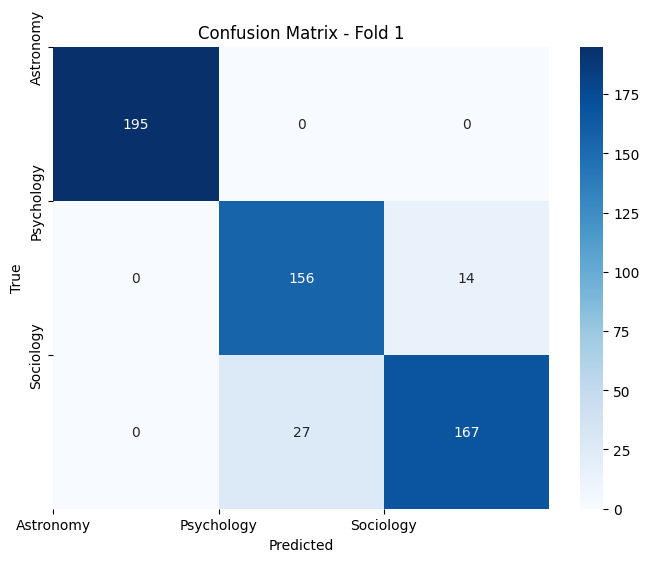

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 2/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_40486/3954821614.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▎         | 21/840 [00:34<21:04,  1.54s/it]

{'loss': 0.9107, 'grad_norm': 2.7952489852905273, 'learning_rate': 1.95e-05, 'epoch': 0.07}


  5%|▌         | 42/840 [01:07<19:56,  1.50s/it]

{'loss': 0.4841, 'grad_norm': 2.39247989654541, 'learning_rate': 1.9e-05, 'epoch': 0.15}


  8%|▊         | 63/840 [01:39<19:44,  1.52s/it]

{'loss': 0.305, 'grad_norm': 3.241551399230957, 'learning_rate': 1.8500000000000002e-05, 'epoch': 0.23}


 10%|█         | 84/840 [02:12<19:31,  1.55s/it]

{'loss': 0.2484, 'grad_norm': 4.149532318115234, 'learning_rate': 1.8e-05, 'epoch': 0.3}


 12%|█▎        | 105/840 [02:46<19:48,  1.62s/it]

{'loss': 0.2814, 'grad_norm': 16.9305419921875, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}


 15%|█▌        | 126/840 [03:21<18:04,  1.52s/it]

{'loss': 0.3312, 'grad_norm': 0.7203433513641357, 'learning_rate': 1.7e-05, 'epoch': 0.45}


 18%|█▊        | 147/840 [03:56<19:20,  1.67s/it]

{'loss': 0.1773, 'grad_norm': 1.8150662183761597, 'learning_rate': 1.65e-05, 'epoch': 0.53}


 20%|██        | 168/840 [04:28<17:10,  1.53s/it]

{'loss': 0.2159, 'grad_norm': 16.503952026367188, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}


 22%|██▎       | 189/840 [05:02<16:59,  1.57s/it]

{'loss': 0.1691, 'grad_norm': 10.329869270324707, 'learning_rate': 1.55e-05, 'epoch': 0.68}


 25%|██▌       | 210/840 [05:34<16:01,  1.53s/it]

{'loss': 0.1656, 'grad_norm': 7.650261878967285, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}


 28%|██▊       | 231/840 [06:06<15:44,  1.55s/it]

{'loss': 0.2287, 'grad_norm': 6.859354496002197, 'learning_rate': 1.45e-05, 'epoch': 0.82}


 30%|███       | 252/840 [06:39<14:51,  1.52s/it]

{'loss': 0.1337, 'grad_norm': 2.4677207469940186, 'learning_rate': 1.4e-05, 'epoch': 0.9}


 32%|███▎      | 273/840 [07:11<14:24,  1.52s/it]

{'loss': 0.1654, 'grad_norm': 0.36328956484794617, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.97}


                                                 
 33%|███▎      | 280/840 [07:54<12:04,  1.29s/it]

{'eval_loss': 0.28091686964035034, 'eval_runtime': 32.7142, 'eval_samples_per_second': 17.057, 'eval_steps_per_second': 2.14, 'epoch': 1.0}


 35%|███▌      | 294/840 [08:17<15:01,  1.65s/it]  

{'loss': 0.1728, 'grad_norm': 0.31636232137680054, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.05}


 38%|███▊      | 315/840 [08:50<13:35,  1.55s/it]

{'loss': 0.1514, 'grad_norm': 0.10805629938840866, 'learning_rate': 1.25e-05, 'epoch': 1.12}


 40%|████      | 336/840 [09:23<12:49,  1.53s/it]

{'loss': 0.1304, 'grad_norm': 4.223059177398682, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 42%|████▎     | 357/840 [09:56<12:22,  1.54s/it]

{'loss': 0.1486, 'grad_norm': 2.527611494064331, 'learning_rate': 1.15e-05, 'epoch': 1.27}


 45%|████▌     | 378/840 [10:29<12:09,  1.58s/it]

{'loss': 0.1905, 'grad_norm': 0.39603281021118164, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.35}


 48%|████▊     | 399/840 [11:06<11:50,  1.61s/it]

{'loss': 0.0919, 'grad_norm': 0.09966795891523361, 'learning_rate': 1.0500000000000001e-05, 'epoch': 1.43}


 50%|█████     | 420/840 [11:39<10:54,  1.56s/it]

{'loss': 0.2133, 'grad_norm': 0.3675808608531952, 'learning_rate': 1e-05, 'epoch': 1.5}


 52%|█████▎    | 441/840 [12:12<10:34,  1.59s/it]

{'loss': 0.143, 'grad_norm': 15.109131813049316, 'learning_rate': 9.5e-06, 'epoch': 1.57}


 55%|█████▌    | 462/840 [12:45<09:48,  1.56s/it]

{'loss': 0.1533, 'grad_norm': 5.05796480178833, 'learning_rate': 9e-06, 'epoch': 1.65}


 57%|█████▊    | 483/840 [13:18<09:22,  1.57s/it]

{'loss': 0.0949, 'grad_norm': 0.4540866017341614, 'learning_rate': 8.5e-06, 'epoch': 1.73}


 60%|██████    | 504/840 [13:52<08:50,  1.58s/it]

{'loss': 0.1719, 'grad_norm': 1.2089941501617432, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}


 62%|██████▎   | 525/840 [14:25<08:04,  1.54s/it]

{'loss': 0.0697, 'grad_norm': 12.555399894714355, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


 65%|██████▌   | 546/840 [14:58<07:31,  1.54s/it]

{'loss': 0.1673, 'grad_norm': 0.9796222448348999, 'learning_rate': 7e-06, 'epoch': 1.95}


                                                 
 67%|██████▋   | 560/840 [15:51<05:29,  1.18s/it]

{'eval_loss': 0.27574023604393005, 'eval_runtime': 33.1283, 'eval_samples_per_second': 16.844, 'eval_steps_per_second': 2.113, 'epoch': 2.0}


 68%|██████▊   | 567/840 [16:05<12:28,  2.74s/it]

{'loss': 0.1365, 'grad_norm': 19.39474868774414, 'learning_rate': 6.5000000000000004e-06, 'epoch': 2.02}


 70%|███████   | 588/840 [16:38<06:41,  1.59s/it]

{'loss': 0.0874, 'grad_norm': 0.23974615335464478, 'learning_rate': 6e-06, 'epoch': 2.1}


 72%|███████▎  | 609/840 [17:11<05:57,  1.55s/it]

{'loss': 0.0474, 'grad_norm': 0.08406515419483185, 'learning_rate': 5.500000000000001e-06, 'epoch': 2.17}


 75%|███████▌  | 630/840 [17:43<05:30,  1.57s/it]

{'loss': 0.134, 'grad_norm': 0.0816899836063385, 'learning_rate': 5e-06, 'epoch': 2.25}


 78%|███████▊  | 651/840 [18:17<04:52,  1.55s/it]

{'loss': 0.1359, 'grad_norm': 0.09334856271743774, 'learning_rate': 4.5e-06, 'epoch': 2.33}


 80%|████████  | 672/840 [18:50<04:21,  1.55s/it]

{'loss': 0.0672, 'grad_norm': 0.2661302983760834, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 82%|████████▎ | 693/840 [19:24<03:54,  1.60s/it]

{'loss': 0.0591, 'grad_norm': 8.419319152832031, 'learning_rate': 3.5e-06, 'epoch': 2.48}


 85%|████████▌ | 714/840 [19:56<03:15,  1.55s/it]

{'loss': 0.0297, 'grad_norm': 0.1322634369134903, 'learning_rate': 3e-06, 'epoch': 2.55}


 88%|████████▊ | 735/840 [20:30<02:46,  1.58s/it]

{'loss': 0.0655, 'grad_norm': 30.72500228881836, 'learning_rate': 2.5e-06, 'epoch': 2.62}


 90%|█████████ | 756/840 [21:04<02:27,  1.75s/it]

{'loss': 0.0746, 'grad_norm': 0.12382987141609192, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.7}


 92%|█████████▎| 777/840 [21:39<01:39,  1.59s/it]

{'loss': 0.0723, 'grad_norm': 0.16143500804901123, 'learning_rate': 1.5e-06, 'epoch': 2.77}


 95%|█████████▌| 798/840 [22:14<01:18,  1.87s/it]

{'loss': 0.0356, 'grad_norm': 7.0927863121032715, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.85}


 98%|█████████▊| 819/840 [22:48<00:33,  1.57s/it]

{'loss': 0.0572, 'grad_norm': 0.08431188762187958, 'learning_rate': 5.000000000000001e-07, 'epoch': 2.92}


100%|██████████| 840/840 [23:20<00:00,  1.21s/it]

{'loss': 0.1271, 'grad_norm': 0.09431245923042297, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 840/840 [23:54<00:00,  1.21s/it]

{'eval_loss': 0.27209970355033875, 'eval_runtime': 32.543, 'eval_samples_per_second': 17.147, 'eval_steps_per_second': 2.151, 'epoch': 3.0}


100%|██████████| 840/840 [23:56<00:00,  1.71s/it]


{'train_runtime': 1436.6384, 'train_samples_per_second': 4.663, 'train_steps_per_second': 0.585, 'train_loss': 0.1711223814459074, 'epoch': 3.0}


100%|██████████| 70/70 [00:32<00:00,  2.14it/s]


Fold 2 Evaluation Results: {'eval_loss': 0.27209970355033875, 'eval_runtime': 32.7229, 'eval_samples_per_second': 17.052, 'eval_steps_per_second': 2.139, 'epoch': 3.0}


100%|██████████| 70/70 [00:33<00:00,  2.11it/s]


Test Accuracy: 0.9301
Fold 2 Confusion Matrix:
[[171   0   1]
 [  0 182  14]
 [  0  24 166]]
Fold 2 Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      0.99      1.00       172
  Psychology       0.88      0.93      0.91       196
   Sociology       0.92      0.87      0.89       190

    accuracy                           0.93       558
   macro avg       0.93      0.93      0.93       558
weighted avg       0.93      0.93      0.93       558



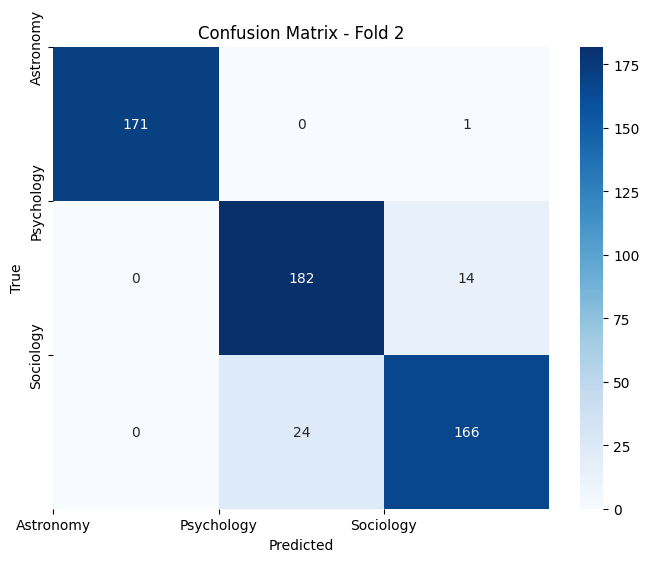

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 3/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_40486/3954821614.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▎         | 21/840 [00:33<21:59,  1.61s/it]

{'loss': 0.9086, 'grad_norm': 3.224198818206787, 'learning_rate': 1.95e-05, 'epoch': 0.07}


  5%|▌         | 42/840 [01:06<20:54,  1.57s/it]

{'loss': 0.4807, 'grad_norm': 6.340152740478516, 'learning_rate': 1.9e-05, 'epoch': 0.15}


  8%|▊         | 63/840 [01:40<20:28,  1.58s/it]

{'loss': 0.3181, 'grad_norm': 4.673482894897461, 'learning_rate': 1.8500000000000002e-05, 'epoch': 0.23}


 10%|█         | 84/840 [02:13<19:27,  1.54s/it]

{'loss': 0.2773, 'grad_norm': 0.9277573227882385, 'learning_rate': 1.8e-05, 'epoch': 0.3}


 12%|█▎        | 105/840 [02:46<19:24,  1.58s/it]

{'loss': 0.1849, 'grad_norm': 0.6430246233940125, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}


 15%|█▌        | 126/840 [03:19<18:11,  1.53s/it]

{'loss': 0.2754, 'grad_norm': 14.03425121307373, 'learning_rate': 1.7e-05, 'epoch': 0.45}


 18%|█▊        | 147/840 [03:51<17:49,  1.54s/it]

{'loss': 0.2235, 'grad_norm': 9.159972190856934, 'learning_rate': 1.65e-05, 'epoch': 0.53}


 20%|██        | 168/840 [04:24<17:58,  1.61s/it]

{'loss': 0.1598, 'grad_norm': 0.3747174143791199, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}


 22%|██▎       | 189/840 [04:57<16:53,  1.56s/it]

{'loss': 0.175, 'grad_norm': 8.997479438781738, 'learning_rate': 1.55e-05, 'epoch': 0.68}


 25%|██▌       | 210/840 [05:30<16:25,  1.56s/it]

{'loss': 0.3077, 'grad_norm': 1.5294228792190552, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}


 28%|██▊       | 231/840 [06:03<16:07,  1.59s/it]

{'loss': 0.2871, 'grad_norm': 0.31322088837623596, 'learning_rate': 1.45e-05, 'epoch': 0.82}


 30%|███       | 252/840 [06:35<15:06,  1.54s/it]

{'loss': 0.1671, 'grad_norm': 1.66714608669281, 'learning_rate': 1.4e-05, 'epoch': 0.9}


 32%|███▎      | 273/840 [07:08<14:51,  1.57s/it]

{'loss': 0.2516, 'grad_norm': 3.938573122024536, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.97}


                                                 
 33%|███▎      | 280/840 [07:51<11:09,  1.20s/it]

{'eval_loss': 0.2816011607646942, 'eval_runtime': 33.1171, 'eval_samples_per_second': 16.849, 'eval_steps_per_second': 2.114, 'epoch': 1.0}


 35%|███▌      | 294/840 [08:14<15:03,  1.65s/it]  

{'loss': 0.1969, 'grad_norm': 14.363550186157227, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.05}


 38%|███▊      | 315/840 [08:48<13:47,  1.58s/it]

{'loss': 0.155, 'grad_norm': 1.8423725366592407, 'learning_rate': 1.25e-05, 'epoch': 1.12}


 40%|████      | 336/840 [09:21<13:27,  1.60s/it]

{'loss': 0.2254, 'grad_norm': 13.378763198852539, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 42%|████▎     | 357/840 [09:55<12:36,  1.57s/it]

{'loss': 0.1126, 'grad_norm': 0.9900076389312744, 'learning_rate': 1.15e-05, 'epoch': 1.27}


 45%|████▌     | 378/840 [10:28<12:05,  1.57s/it]

{'loss': 0.1582, 'grad_norm': 3.0291123390197754, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.35}


 48%|████▊     | 399/840 [11:02<12:26,  1.69s/it]

{'loss': 0.1088, 'grad_norm': 17.915422439575195, 'learning_rate': 1.0500000000000001e-05, 'epoch': 1.43}


 50%|█████     | 420/840 [11:35<10:32,  1.51s/it]

{'loss': 0.225, 'grad_norm': 14.944052696228027, 'learning_rate': 1e-05, 'epoch': 1.5}


 52%|█████▎    | 441/840 [12:07<10:10,  1.53s/it]

{'loss': 0.1379, 'grad_norm': 0.17150487005710602, 'learning_rate': 9.5e-06, 'epoch': 1.57}


 55%|█████▌    | 462/840 [12:39<09:10,  1.46s/it]

{'loss': 0.1819, 'grad_norm': 0.36183255910873413, 'learning_rate': 9e-06, 'epoch': 1.65}


 57%|█████▊    | 483/840 [13:10<08:49,  1.48s/it]

{'loss': 0.1141, 'grad_norm': 6.336038112640381, 'learning_rate': 8.5e-06, 'epoch': 1.73}


 60%|██████    | 504/840 [13:40<08:08,  1.45s/it]

{'loss': 0.0925, 'grad_norm': 0.38424819707870483, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}


 62%|██████▎   | 525/840 [14:11<07:47,  1.49s/it]

{'loss': 0.0912, 'grad_norm': 10.751428604125977, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


 65%|██████▌   | 546/840 [14:42<07:05,  1.45s/it]

{'loss': 0.1271, 'grad_norm': 0.1914822906255722, 'learning_rate': 7e-06, 'epoch': 1.95}


                                                 
 67%|██████▋   | 560/840 [15:33<05:08,  1.10s/it]

{'eval_loss': 0.1486271619796753, 'eval_runtime': 31.478, 'eval_samples_per_second': 17.727, 'eval_steps_per_second': 2.224, 'epoch': 2.0}


 68%|██████▊   | 567/840 [15:45<11:48,  2.60s/it]

{'loss': 0.1468, 'grad_norm': 0.13774517178535461, 'learning_rate': 6.5000000000000004e-06, 'epoch': 2.02}


 70%|███████   | 588/840 [16:16<06:10,  1.47s/it]

{'loss': 0.123, 'grad_norm': 0.18137910962104797, 'learning_rate': 6e-06, 'epoch': 2.1}


 72%|███████▎  | 609/840 [16:47<05:35,  1.45s/it]

{'loss': 0.0298, 'grad_norm': 0.2397928535938263, 'learning_rate': 5.500000000000001e-06, 'epoch': 2.17}


 75%|███████▌  | 630/840 [17:18<05:04,  1.45s/it]

{'loss': 0.0654, 'grad_norm': 0.06986796855926514, 'learning_rate': 5e-06, 'epoch': 2.25}


 78%|███████▊  | 651/840 [17:48<04:37,  1.47s/it]

{'loss': 0.1275, 'grad_norm': 0.22524286806583405, 'learning_rate': 4.5e-06, 'epoch': 2.33}


 80%|████████  | 672/840 [18:20<04:09,  1.49s/it]

{'loss': 0.1117, 'grad_norm': 0.07970885932445526, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 82%|████████▎ | 693/840 [18:50<03:32,  1.45s/it]

{'loss': 0.106, 'grad_norm': 0.0621521919965744, 'learning_rate': 3.5e-06, 'epoch': 2.48}


 85%|████████▌ | 714/840 [19:21<03:06,  1.48s/it]

{'loss': 0.1592, 'grad_norm': 14.834339141845703, 'learning_rate': 3e-06, 'epoch': 2.55}


 88%|████████▊ | 735/840 [19:52<02:32,  1.46s/it]

{'loss': 0.1316, 'grad_norm': 17.092012405395508, 'learning_rate': 2.5e-06, 'epoch': 2.62}


 90%|█████████ | 756/840 [20:23<02:03,  1.47s/it]

{'loss': 0.0516, 'grad_norm': 5.152332782745361, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.7}


 92%|█████████▎| 777/840 [20:54<01:34,  1.50s/it]

{'loss': 0.0538, 'grad_norm': 0.18852727115154266, 'learning_rate': 1.5e-06, 'epoch': 2.77}


 95%|█████████▌| 798/840 [21:25<01:04,  1.53s/it]

{'loss': 0.0332, 'grad_norm': 0.4857842028141022, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.85}


 98%|█████████▊| 819/840 [22:02<00:33,  1.57s/it]

{'loss': 0.1109, 'grad_norm': 0.07642719894647598, 'learning_rate': 5.000000000000001e-07, 'epoch': 2.92}


100%|██████████| 840/840 [22:34<00:00,  1.23s/it]

{'loss': 0.0349, 'grad_norm': 0.04704480990767479, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 840/840 [23:08<00:00,  1.23s/it]

{'eval_loss': 0.15656964480876923, 'eval_runtime': 32.5165, 'eval_samples_per_second': 17.16, 'eval_steps_per_second': 2.153, 'epoch': 3.0}


100%|██████████| 840/840 [23:10<00:00,  1.66s/it]


{'train_runtime': 1390.4751, 'train_samples_per_second': 4.818, 'train_steps_per_second': 0.604, 'train_loss': 0.1807185621488662, 'epoch': 3.0}


100%|██████████| 70/70 [00:33<00:00,  2.11it/s]


Fold 3 Evaluation Results: {'eval_loss': 0.1486271619796753, 'eval_runtime': 33.1917, 'eval_samples_per_second': 16.811, 'eval_steps_per_second': 2.109, 'epoch': 3.0}


100%|██████████| 70/70 [00:33<00:00,  2.10it/s]


Test Accuracy: 0.9552
Fold 3 Confusion Matrix:
[[170   0   0]
 [  0 180  12]
 [  1  12 183]]
Fold 3 Classification Report:
              precision    recall  f1-score   support

   Astronomy       0.99      1.00      1.00       170
  Psychology       0.94      0.94      0.94       192
   Sociology       0.94      0.93      0.94       196

    accuracy                           0.96       558
   macro avg       0.96      0.96      0.96       558
weighted avg       0.96      0.96      0.96       558



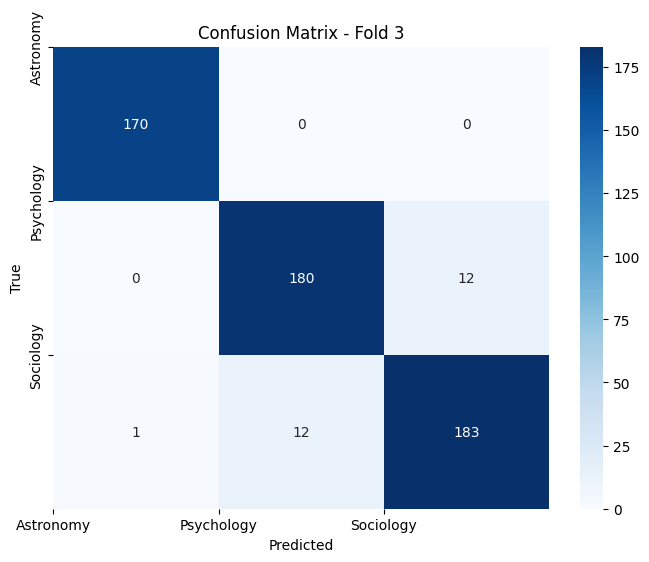

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 4/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_40486/3954821614.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▎         | 21/840 [00:32<21:36,  1.58s/it]

{'loss': 0.884, 'grad_norm': 3.0271034240722656, 'learning_rate': 1.95e-05, 'epoch': 0.07}


  5%|▌         | 42/840 [01:04<20:36,  1.55s/it]

{'loss': 0.5133, 'grad_norm': 2.665947675704956, 'learning_rate': 1.9e-05, 'epoch': 0.15}


  8%|▊         | 63/840 [01:37<20:30,  1.58s/it]

{'loss': 0.3196, 'grad_norm': 5.257469654083252, 'learning_rate': 1.8500000000000002e-05, 'epoch': 0.23}


 10%|█         | 84/840 [02:12<20:18,  1.61s/it]

{'loss': 0.2021, 'grad_norm': 3.1594107151031494, 'learning_rate': 1.8e-05, 'epoch': 0.3}


 12%|█▎        | 105/840 [02:44<18:49,  1.54s/it]

{'loss': 0.3209, 'grad_norm': 12.489951133728027, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}


 15%|█▌        | 126/840 [03:18<19:02,  1.60s/it]

{'loss': 0.2893, 'grad_norm': 20.3740234375, 'learning_rate': 1.7e-05, 'epoch': 0.45}


 18%|█▊        | 147/840 [03:52<18:33,  1.61s/it]

{'loss': 0.257, 'grad_norm': 7.335209369659424, 'learning_rate': 1.65e-05, 'epoch': 0.53}


 20%|██        | 168/840 [04:25<17:30,  1.56s/it]

{'loss': 0.145, 'grad_norm': 0.462869256734848, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}


 22%|██▎       | 189/840 [04:58<17:10,  1.58s/it]

{'loss': 0.1943, 'grad_norm': 4.148538589477539, 'learning_rate': 1.55e-05, 'epoch': 0.68}


 25%|██▌       | 210/840 [05:32<16:33,  1.58s/it]

{'loss': 0.2967, 'grad_norm': 0.4330551028251648, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}


 28%|██▊       | 231/840 [06:05<16:06,  1.59s/it]

{'loss': 0.2711, 'grad_norm': 2.0771398544311523, 'learning_rate': 1.45e-05, 'epoch': 0.82}


 30%|███       | 252/840 [06:38<15:26,  1.58s/it]

{'loss': 0.3064, 'grad_norm': 7.806941509246826, 'learning_rate': 1.4e-05, 'epoch': 0.9}


 32%|███▎      | 273/840 [07:12<15:10,  1.61s/it]

{'loss': 0.1347, 'grad_norm': 8.87222957611084, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.97}


                                                 
 33%|███▎      | 280/840 [07:56<11:43,  1.26s/it]

{'eval_loss': 0.21072722971439362, 'eval_runtime': 33.3085, 'eval_samples_per_second': 16.752, 'eval_steps_per_second': 2.102, 'epoch': 1.0}


 35%|███▌      | 294/840 [08:20<15:43,  1.73s/it]  

{'loss': 0.0616, 'grad_norm': 11.106584548950195, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.05}


 38%|███▊      | 315/840 [08:53<13:22,  1.53s/it]

{'loss': 0.151, 'grad_norm': 9.553022384643555, 'learning_rate': 1.25e-05, 'epoch': 1.12}


 40%|████      | 336/840 [09:26<13:07,  1.56s/it]

{'loss': 0.3115, 'grad_norm': 0.2596605122089386, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 42%|████▎     | 357/840 [09:59<12:29,  1.55s/it]

{'loss': 0.2038, 'grad_norm': 0.5158358812332153, 'learning_rate': 1.15e-05, 'epoch': 1.27}


 45%|████▌     | 378/840 [10:32<11:53,  1.54s/it]

{'loss': 0.04, 'grad_norm': 0.22399722039699554, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.35}


 48%|████▊     | 399/840 [11:07<11:59,  1.63s/it]

{'loss': 0.1831, 'grad_norm': 2.656235933303833, 'learning_rate': 1.0500000000000001e-05, 'epoch': 1.43}


 50%|█████     | 420/840 [11:39<10:52,  1.55s/it]

{'loss': 0.2104, 'grad_norm': 0.20626644790172577, 'learning_rate': 1e-05, 'epoch': 1.5}


 52%|█████▎    | 441/840 [12:12<10:24,  1.57s/it]

{'loss': 0.0789, 'grad_norm': 0.09568750113248825, 'learning_rate': 9.5e-06, 'epoch': 1.57}


 55%|█████▌    | 462/840 [12:45<09:36,  1.53s/it]

{'loss': 0.03, 'grad_norm': 0.07145092636346817, 'learning_rate': 9e-06, 'epoch': 1.65}


 57%|█████▊    | 483/840 [13:17<08:52,  1.49s/it]

{'loss': 0.1108, 'grad_norm': 4.603267669677734, 'learning_rate': 8.5e-06, 'epoch': 1.73}


 60%|██████    | 504/840 [13:48<08:22,  1.50s/it]

{'loss': 0.1748, 'grad_norm': 0.14250417053699493, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}


 62%|██████▎   | 525/840 [14:19<07:41,  1.46s/it]

{'loss': 0.117, 'grad_norm': 0.12995973229408264, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


 65%|██████▌   | 546/840 [14:50<07:15,  1.48s/it]

{'loss': 0.1279, 'grad_norm': 0.08186432719230652, 'learning_rate': 7e-06, 'epoch': 1.95}


                                                 
 67%|██████▋   | 560/840 [15:42<05:14,  1.12s/it]

{'eval_loss': 0.24403996765613556, 'eval_runtime': 31.7702, 'eval_samples_per_second': 17.564, 'eval_steps_per_second': 2.203, 'epoch': 2.0}


 68%|██████▊   | 567/840 [15:54<11:54,  2.62s/it]

{'loss': 0.1221, 'grad_norm': 0.09732246398925781, 'learning_rate': 6.5000000000000004e-06, 'epoch': 2.02}


 70%|███████   | 588/840 [16:25<06:19,  1.50s/it]

{'loss': 0.1433, 'grad_norm': 0.06070234254002571, 'learning_rate': 6e-06, 'epoch': 2.1}


 72%|███████▎  | 609/840 [16:56<05:35,  1.45s/it]

{'loss': 0.0467, 'grad_norm': 2.1146252155303955, 'learning_rate': 5.500000000000001e-06, 'epoch': 2.17}


 75%|███████▌  | 630/840 [17:27<05:11,  1.48s/it]

{'loss': 0.0879, 'grad_norm': 0.05283844470977783, 'learning_rate': 5e-06, 'epoch': 2.25}


 78%|███████▊  | 651/840 [17:58<04:39,  1.48s/it]

{'loss': 0.0462, 'grad_norm': 0.10191494226455688, 'learning_rate': 4.5e-06, 'epoch': 2.33}


 80%|████████  | 672/840 [18:29<04:05,  1.46s/it]

{'loss': 0.1614, 'grad_norm': 4.775504112243652, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 82%|████████▎ | 693/840 [19:00<03:41,  1.50s/it]

{'loss': 0.1419, 'grad_norm': 0.050872549414634705, 'learning_rate': 3.5e-06, 'epoch': 2.48}


 85%|████████▌ | 714/840 [19:32<03:09,  1.51s/it]

{'loss': 0.0753, 'grad_norm': 0.10142362117767334, 'learning_rate': 3e-06, 'epoch': 2.55}


 88%|████████▊ | 735/840 [20:02<02:32,  1.45s/it]

{'loss': 0.0776, 'grad_norm': 0.0956365242600441, 'learning_rate': 2.5e-06, 'epoch': 2.62}


 90%|█████████ | 756/840 [20:33<02:03,  1.47s/it]

{'loss': 0.0605, 'grad_norm': 0.09991998225450516, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.7}


 92%|█████████▎| 777/840 [21:04<01:34,  1.51s/it]

{'loss': 0.0573, 'grad_norm': 0.8229432702064514, 'learning_rate': 1.5e-06, 'epoch': 2.77}


 95%|█████████▌| 798/840 [21:36<01:01,  1.46s/it]

{'loss': 0.1013, 'grad_norm': 0.09687738120555878, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.85}


 98%|█████████▊| 819/840 [22:06<00:30,  1.47s/it]

{'loss': 0.0103, 'grad_norm': 0.11092641204595566, 'learning_rate': 5.000000000000001e-07, 'epoch': 2.92}


100%|██████████| 840/840 [22:36<00:00,  1.14s/it]

{'loss': 0.1065, 'grad_norm': 0.13044823706150055, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 840/840 [23:10<00:00,  1.14s/it]

{'eval_loss': 0.23958849906921387, 'eval_runtime': 31.4625, 'eval_samples_per_second': 17.735, 'eval_steps_per_second': 2.225, 'epoch': 3.0}


100%|██████████| 840/840 [23:11<00:00,  1.66s/it]


{'train_runtime': 1391.4034, 'train_samples_per_second': 4.815, 'train_steps_per_second': 0.604, 'train_loss': 0.17933688089251518, 'epoch': 3.0}


100%|██████████| 70/70 [00:31<00:00,  2.25it/s]


Fold 4 Evaluation Results: {'eval_loss': 0.21072722971439362, 'eval_runtime': 31.1658, 'eval_samples_per_second': 17.904, 'eval_steps_per_second': 2.246, 'epoch': 3.0}


100%|██████████| 70/70 [00:31<00:00,  2.24it/s]


Test Accuracy: 0.9355
Fold 4 Confusion Matrix:
[[203   0   0]
 [  0 161  14]
 [  0  22 158]]
Fold 4 Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00       203
  Psychology       0.88      0.92      0.90       175
   Sociology       0.92      0.88      0.90       180

    accuracy                           0.94       558
   macro avg       0.93      0.93      0.93       558
weighted avg       0.94      0.94      0.94       558



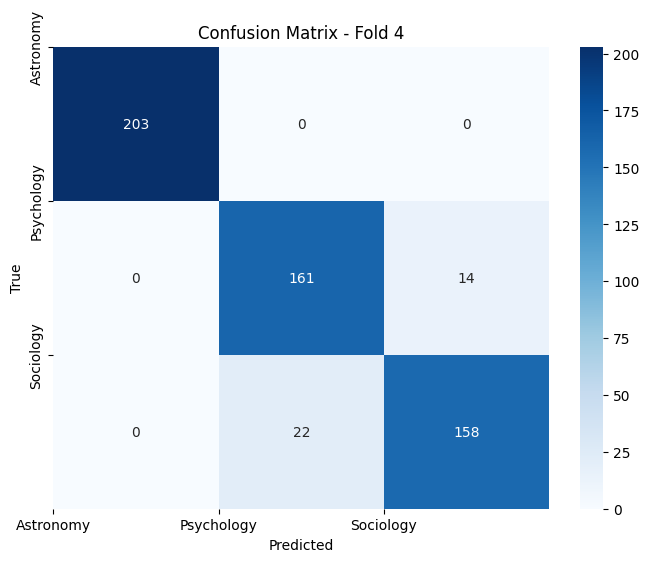

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fold 5/5


/Users/userinfo/Desktop/ISSE Fourth Sem/Artificial intelligence /AI model training/scraping/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/9d/dsx_p3092f17cgrz2k1t1zrh0000gn/T/ipykernel_40486/3954821614.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  2%|▎         | 21/840 [00:30<19:48,  1.45s/it]

{'loss': 0.9025, 'grad_norm': 3.6721153259277344, 'learning_rate': 1.95e-05, 'epoch': 0.07}


  5%|▌         | 42/840 [01:05<21:07,  1.59s/it]

{'loss': 0.4983, 'grad_norm': 4.775336265563965, 'learning_rate': 1.9e-05, 'epoch': 0.15}


  8%|▊         | 63/840 [01:39<19:54,  1.54s/it]

{'loss': 0.3379, 'grad_norm': 2.658907413482666, 'learning_rate': 1.8500000000000002e-05, 'epoch': 0.23}


 10%|█         | 84/840 [02:12<20:24,  1.62s/it]

{'loss': 0.2456, 'grad_norm': 6.212894916534424, 'learning_rate': 1.8e-05, 'epoch': 0.3}


 12%|█▎        | 105/840 [02:46<19:21,  1.58s/it]

{'loss': 0.1808, 'grad_norm': 3.983158588409424, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.38}


 15%|█▌        | 126/840 [03:19<18:39,  1.57s/it]

{'loss': 0.3712, 'grad_norm': 11.33934497833252, 'learning_rate': 1.7e-05, 'epoch': 0.45}


 18%|█▊        | 147/840 [03:53<18:32,  1.61s/it]

{'loss': 0.1584, 'grad_norm': 12.183206558227539, 'learning_rate': 1.65e-05, 'epoch': 0.53}


 20%|██        | 168/840 [04:26<17:34,  1.57s/it]

{'loss': 0.2675, 'grad_norm': 12.945921897888184, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.6}


 22%|██▎       | 189/840 [04:59<17:14,  1.59s/it]

{'loss': 0.1581, 'grad_norm': 5.707701206207275, 'learning_rate': 1.55e-05, 'epoch': 0.68}


 25%|██▌       | 210/840 [05:32<16:25,  1.56s/it]

{'loss': 0.1417, 'grad_norm': 0.18799550831317902, 'learning_rate': 1.5000000000000002e-05, 'epoch': 0.75}


 28%|██▊       | 231/840 [06:05<16:06,  1.59s/it]

{'loss': 0.3285, 'grad_norm': 3.7568273544311523, 'learning_rate': 1.45e-05, 'epoch': 0.82}


 30%|███       | 252/840 [06:38<15:07,  1.54s/it]

{'loss': 0.2204, 'grad_norm': 5.300323009490967, 'learning_rate': 1.4e-05, 'epoch': 0.9}


 32%|███▎      | 273/840 [07:12<15:09,  1.60s/it]

{'loss': 0.1312, 'grad_norm': 0.8621028065681458, 'learning_rate': 1.3500000000000001e-05, 'epoch': 0.97}


                                                 
 33%|███▎      | 280/840 [07:55<11:41,  1.25s/it]

{'eval_loss': 0.27630794048309326, 'eval_runtime': 33.4266, 'eval_samples_per_second': 16.693, 'eval_steps_per_second': 2.094, 'epoch': 1.0}


 35%|███▌      | 294/840 [08:20<15:47,  1.74s/it]  

{'loss': 0.1057, 'grad_norm': 0.20448550581932068, 'learning_rate': 1.3000000000000001e-05, 'epoch': 1.05}


 38%|███▊      | 315/840 [08:54<14:07,  1.61s/it]

{'loss': 0.1379, 'grad_norm': 0.08940392732620239, 'learning_rate': 1.25e-05, 'epoch': 1.12}


 40%|████      | 336/840 [09:27<13:16,  1.58s/it]

{'loss': 0.2618, 'grad_norm': 2.6061322689056396, 'learning_rate': 1.2e-05, 'epoch': 1.2}


 42%|████▎     | 357/840 [10:01<12:54,  1.60s/it]

{'loss': 0.1335, 'grad_norm': 1.2674741744995117, 'learning_rate': 1.15e-05, 'epoch': 1.27}


 45%|████▌     | 378/840 [10:34<12:19,  1.60s/it]

{'loss': 0.1017, 'grad_norm': 0.13323351740837097, 'learning_rate': 1.1000000000000001e-05, 'epoch': 1.35}


 48%|████▊     | 399/840 [11:09<12:12,  1.66s/it]

{'loss': 0.2369, 'grad_norm': 4.842075347900391, 'learning_rate': 1.0500000000000001e-05, 'epoch': 1.43}


 50%|█████     | 420/840 [11:41<10:34,  1.51s/it]

{'loss': 0.1222, 'grad_norm': 0.08281447738409042, 'learning_rate': 1e-05, 'epoch': 1.5}


 52%|█████▎    | 441/840 [12:13<10:06,  1.52s/it]

{'loss': 0.1642, 'grad_norm': 0.15212325751781464, 'learning_rate': 9.5e-06, 'epoch': 1.57}


 55%|█████▌    | 462/840 [12:44<09:11,  1.46s/it]

{'loss': 0.1707, 'grad_norm': 14.099555969238281, 'learning_rate': 9e-06, 'epoch': 1.65}


 57%|█████▊    | 483/840 [13:15<08:57,  1.51s/it]

{'loss': 0.1567, 'grad_norm': 0.07302643358707428, 'learning_rate': 8.5e-06, 'epoch': 1.73}


 60%|██████    | 504/840 [13:47<08:36,  1.54s/it]

{'loss': 0.0625, 'grad_norm': 2.0039174556732178, 'learning_rate': 8.000000000000001e-06, 'epoch': 1.8}


 62%|██████▎   | 525/840 [14:18<07:40,  1.46s/it]

{'loss': 0.0756, 'grad_norm': 0.07146618515253067, 'learning_rate': 7.500000000000001e-06, 'epoch': 1.88}


 65%|██████▌   | 546/840 [14:49<07:15,  1.48s/it]

{'loss': 0.1435, 'grad_norm': 9.39051342010498, 'learning_rate': 7e-06, 'epoch': 1.95}


                                                 
 67%|██████▋   | 560/840 [15:40<05:12,  1.12s/it]

{'eval_loss': 0.27390778064727783, 'eval_runtime': 31.8753, 'eval_samples_per_second': 17.506, 'eval_steps_per_second': 2.196, 'epoch': 2.0}


 68%|██████▊   | 567/840 [15:52<11:52,  2.61s/it]

{'loss': 0.0428, 'grad_norm': 5.490650177001953, 'learning_rate': 6.5000000000000004e-06, 'epoch': 2.02}


 70%|███████   | 588/840 [16:23<06:06,  1.45s/it]

{'loss': 0.0828, 'grad_norm': 0.053573478013277054, 'learning_rate': 6e-06, 'epoch': 2.1}


 72%|███████▎  | 609/840 [16:55<05:48,  1.51s/it]

{'loss': 0.11, 'grad_norm': 0.06434833258390427, 'learning_rate': 5.500000000000001e-06, 'epoch': 2.17}


 75%|███████▌  | 630/840 [17:26<05:14,  1.50s/it]

{'loss': 0.0631, 'grad_norm': 0.3038322925567627, 'learning_rate': 5e-06, 'epoch': 2.25}


 78%|███████▊  | 651/840 [17:56<04:38,  1.48s/it]

{'loss': 0.0467, 'grad_norm': 0.18372760713100433, 'learning_rate': 4.5e-06, 'epoch': 2.33}


 80%|████████  | 672/840 [18:27<04:02,  1.45s/it]

{'loss': 0.0115, 'grad_norm': 0.0594361238181591, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.4}


 82%|████████▎ | 693/840 [18:59<03:40,  1.50s/it]

{'loss': 0.1414, 'grad_norm': 0.06276531517505646, 'learning_rate': 3.5e-06, 'epoch': 2.48}


 85%|████████▌ | 714/840 [19:30<03:05,  1.47s/it]

{'loss': 0.0578, 'grad_norm': 3.5160889625549316, 'learning_rate': 3e-06, 'epoch': 2.55}


 88%|████████▊ | 735/840 [20:01<02:32,  1.45s/it]

{'loss': 0.1263, 'grad_norm': 1.3208099603652954, 'learning_rate': 2.5e-06, 'epoch': 2.62}


 90%|█████████ | 756/840 [20:32<02:06,  1.50s/it]

{'loss': 0.0217, 'grad_norm': 2.148381233215332, 'learning_rate': 2.0000000000000003e-06, 'epoch': 2.7}


 92%|█████████▎| 777/840 [21:03<01:33,  1.48s/it]

{'loss': 0.1906, 'grad_norm': 0.09771224111318588, 'learning_rate': 1.5e-06, 'epoch': 2.77}


 95%|█████████▌| 798/840 [21:34<01:02,  1.50s/it]

{'loss': 0.0587, 'grad_norm': 0.06875668466091156, 'learning_rate': 1.0000000000000002e-06, 'epoch': 2.85}


 98%|█████████▊| 819/840 [22:05<00:31,  1.50s/it]

{'loss': 0.101, 'grad_norm': 0.06864622980356216, 'learning_rate': 5.000000000000001e-07, 'epoch': 2.92}


100%|██████████| 840/840 [22:35<00:00,  1.13s/it]

{'loss': 0.103, 'grad_norm': 0.04131149873137474, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 840/840 [23:08<00:00,  1.13s/it]

{'eval_loss': 0.3018876612186432, 'eval_runtime': 31.1416, 'eval_samples_per_second': 17.918, 'eval_steps_per_second': 2.248, 'epoch': 3.0}


100%|██████████| 840/840 [23:10<00:00,  1.65s/it]


{'train_runtime': 1390.0402, 'train_samples_per_second': 4.819, 'train_steps_per_second': 0.604, 'train_loss': 0.17431157712070716, 'epoch': 3.0}


100%|██████████| 70/70 [00:31<00:00,  2.23it/s]


Fold 5 Evaluation Results: {'eval_loss': 0.27390778064727783, 'eval_runtime': 31.3911, 'eval_samples_per_second': 17.776, 'eval_steps_per_second': 2.23, 'epoch': 3.0}


100%|██████████| 70/70 [00:31<00:00,  2.21it/s]


Test Accuracy: 0.9301
Fold 5 Confusion Matrix:
[[160   0   0]
 [  0 181  20]
 [  0  19 178]]
Fold 5 Classification Report:
              precision    recall  f1-score   support

   Astronomy       1.00      1.00      1.00       160
  Psychology       0.91      0.90      0.90       201
   Sociology       0.90      0.90      0.90       197

    accuracy                           0.93       558
   macro avg       0.93      0.93      0.93       558
weighted avg       0.93      0.93      0.93       558



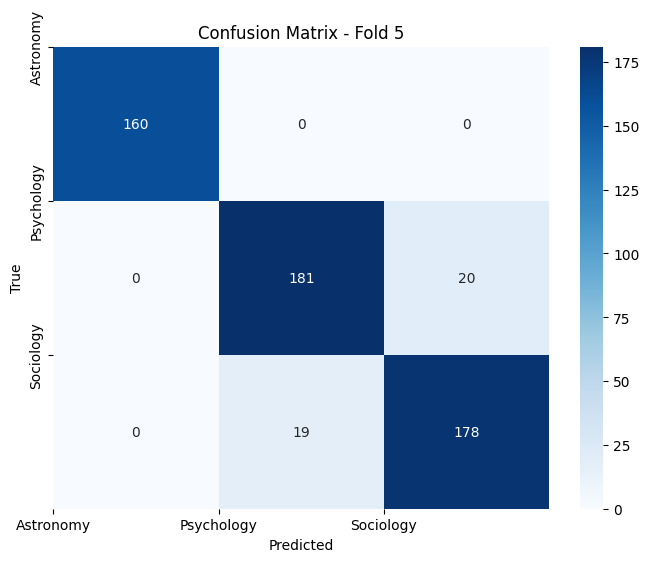

In [10]:
'''
This part does the training. 
'''
num_labels = 3  # Number of categories for the scientific abstract classification
'''
Autoconfig is the module that allows to change the training configuration from the pretrained model
As the pretrained model is being fine tuned, i am changing the configuration a little bit from the original 
distilbert base model. the number of labels is set to 3.Therefore the classification head has been replaced with a classification head of dimension 3. 
The original classification head is a classification head with 768 dimension for 768 dimension inputs.
 The ouput of the final layer of distilbert which is a pooler output is projected into the 3 dimension of the new classification head. 
  The changes in the configurations are-adding dropout of 0.3 for both hidden layers and attention layers to avoid overfitting and probable bias in the astronomy field. These are the changes made in the model configuration.
'''

config = AutoConfig.from_pretrained(
    "distilbert-base-uncased",  
    hidden_dropout_prob=0.3, # Dropout rate for hidden layers
    attention_probs_dropout_prob=0.3 ,# Dropout rate for attention probabilities
     num_labels=3 
)
model_name = 'distilbert-base-uncased'

base_training_args = {
    "evaluation_strategy": "epoch",  # Evaluate at the end of each epoch
    "save_strategy": "epoch",  # Save checkpoints at the end of each epoch
    "learning_rate": 2e-5,  # Learning rate- it's the default one
    "per_device_train_batch_size": 8,  # Training batch size 8 =that's what the device without gpu can handle
    "per_device_eval_batch_size": 8,  # Evaluation batch size same as before
    "num_train_epochs": 3,  # Number of epochs. The choosing of numbers is explained in the report
    "weight_decay": 0.03,  # Weight decay trying to avoid overfitting
    
    "logging_steps": 21,  # Log 837/21=40 times 
    "save_total_limit": 2,  # Limit saved checkpoints

    "load_best_model_at_end": True,  # Load the best model at the end
}

# K-Fold Cross Validation
n_splits = 5  # Number of folds
kf =KFold(n_splits=n_splits, shuffle=True, random_state=42) # i formatted the dataset before to ensure no adjacent rows have same class and dataset seems balanced. that's why using regular kfold
#shuffling might overwrite the formatted dataset. But it still gave good results
# Lists to store evaluation matrix for future use 
accuracy_per_fold = []
val_loss_per_fold = []
losses_per_fold = []  
num_classes = 3  
cumulative_cm = np.zeros((num_classes, num_classes), dtype=int) # This one is used for normalizing the confusion matrix 
foldwise_cm=[]#storing the cm matrix for each fold. Might need to print it in future.


# Loop through each fold
#The kfold module from sklearn is used. Which splits the train dataset in train and test index for 5 folds
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    # Splitting dataset into training and validation sets
    train_fold = train_dataset.select(train_idx) #.select selects only the train indexes and val_indexes
    val_fold = train_dataset.select(val_idx)
    
    # Initialize the model for this fold newly and setting the configuration to the one defined for fine tuning purpose
    model = DistilBertForSequenceClassification.from_pretrained(model_name,config=config)
    
    # Create training arguments specific to the fold
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold + 1}",  # Unique output dir for each fold
        logging_dir=f"./logs_fold_{fold + 1}",  # Unique log dir for each fold
        **base_training_args,
    )
    loss_logger_callback = LossLoggerCallback() #this is going to store the losses for each fold over all epochs
    
    # Instantiate Trainer
    '''
    The trainer class from hugging face that is going to train the model, evaluate it.
    '''
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_fold,
        eval_dataset=val_fold,
        tokenizer=tokenizer,
        callbacks=[loss_logger_callback], #the function defined in the previous cell is being called here 
    )
    
    # Finally the training starts 
    
    trainer.train() # it is going to train on the train dataset only and the eval dataset is still unseen 

    losses_per_fold.append(loss_logger_callback.get_losses()) #keeping track for future use 
    
   
    eval_results = trainer.evaluate() # this is going evaluate the model on the evaluation dataset With help of trainer class and give us accuracy 
    '''   
    Evaluating and testing the model on the same validation dataset is not a good practice. However, in this case 
    the model had to be validated and tested on the same validation dataset because of k fold cross validation. 
    One way would be to just test the model with the predict function below. That is also printing the accuracy and classification report. 
    However as seen in the ouput, accuracy doesn't change at all. The model didn't overfit over the test dataset. 
    This is not a good practice. 

    But i had to do it to get the prediction and true labels for the confusion matrix.
    and to keep track of the accuracy to plot it later to see how the model performed over the folds.
     In practice 
    it should be either eval or predict for kfold validation. This is something i noticed after the training was over. 
    The result didn't change and the model didn't overfit on the validation data as the accuracy is same. In principle 
    it could have caused problems. 
    '''
    
    
    # Computing predictions and true labels for confusion matrix
    predictions, true_labels, _ = trainer.predict(val_fold)  # This is testing the model again on the validation dataset this time to get detail reports . this is returning the predicted labels aka probablity logits of the model and real label of the validation dataset are compared
    pred_labels = np.argmax(predictions, axis=1)
    
    # Computing the  confusion matrix and classification report with sklearn 
    cm = confusion_matrix(true_labels, pred_labels)
    report = classification_report(true_labels,pred_labels, target_names=['Astronomy', 'Psychology', 'Sociology'])
    accuracy=accuracy_score(true_labels,pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels,pred_labels, average=None)  # Per-class metrics
    f1_macro = precision_recall_fscore_support(true_labels,pred_labels, average='macro')[2]
    f1_weighted = precision_recall_fscore_support(true_labels,pred_labels, average='weighted')[2]
    f1_micro = precision_recall_fscore_support(true_labels,pred_labels, average='micro')[2]
    #Print report 
    print("Test Accuracy: {:.4f}".format(accuracy))
    cumulative_cm += cm 
    # Print confusion matrix
    print(f"Fold {fold + 1} Confusion Matrix:")
    print(cm)
    # Print classification report
    print(f"Fold {fold + 1} Classification Report:")
    print(report)
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(num_labels), yticklabels=np.arange(num_labels))
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(3), ['Astronomy', 'Psychology', 'Sociology'])
    plt.yticks(range(3), ['Astronomy', 'Psychology', 'Sociology'])
    plt.show()

    
    # Store accuracy and validation loss for plotting
    accuracy_per_fold.append(accuracy)
    val_loss_per_fold.append(eval_results['eval_loss'])
    foldwise_cm.append(cm)

 

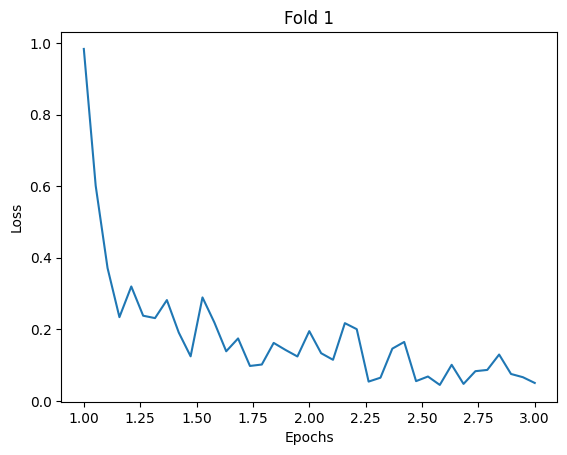

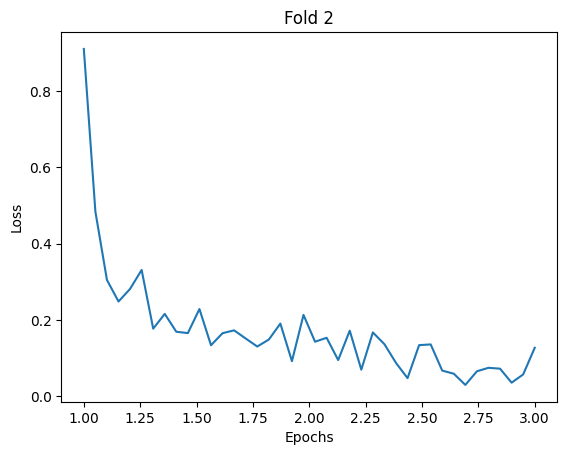

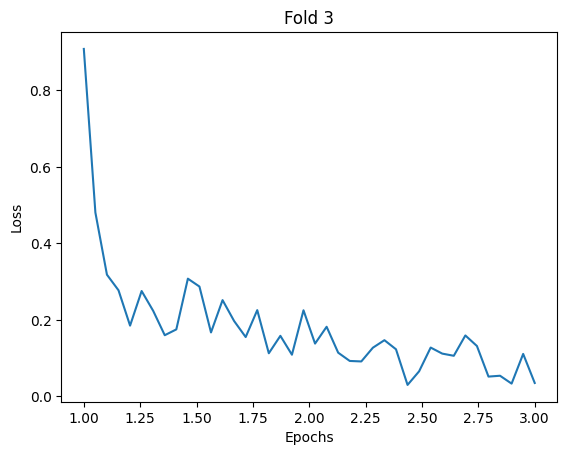

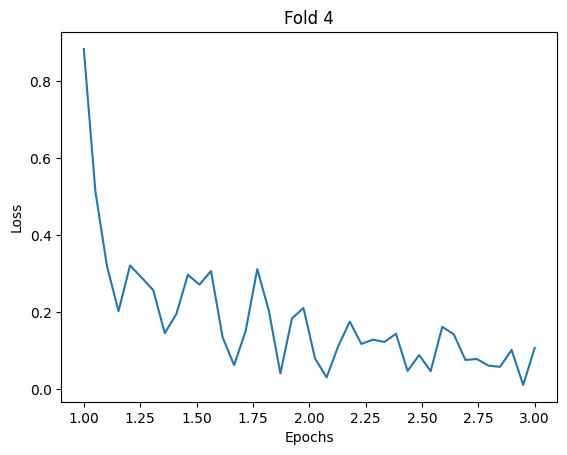

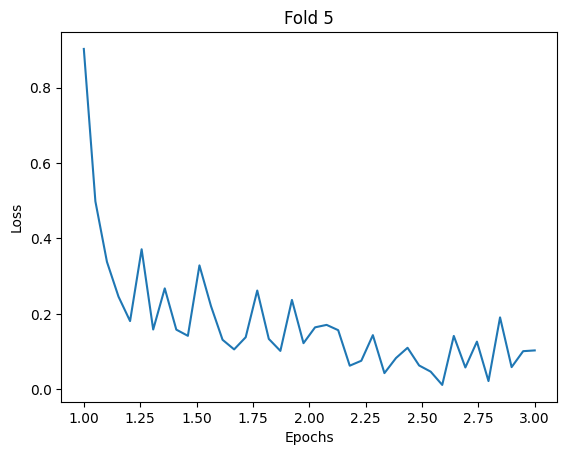

In [11]:

#This part plots the loss vs epoch plot 

folds = [np.array(fold) for fold in losses_per_fold] 

# Creating a separate plot for each fold
for i in range(len(folds)):
    plt.figure()  # Start a new figure for each fold
    
    # Spread 50 data points evenly across 5 epochs (create custom x-axis)
    epochs = np.linspace(1, 3, len(folds[i]))  # Mapping 50 data points to range 1 to 5
    
    plt.plot(epochs, folds[i])  # Plot using custom x-axis (epochs)
    plt.title(f"Fold {i+1}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    # Display the plot
    plt.show()

In [12]:
average_loss=[]
for i in range(5):
    average_loss.append(np.mean(folds[i]))
print(average_loss)


[0.18270512820512821, 0.17112500000000003, 0.18072, 0.17933749999999998, 0.17431000000000002]


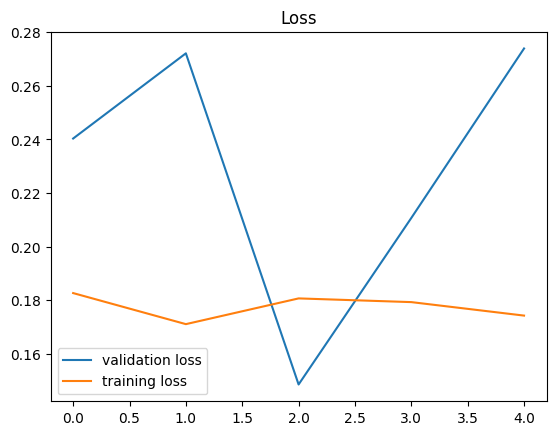

Text(0.5, 1.0, 'Accuracy')

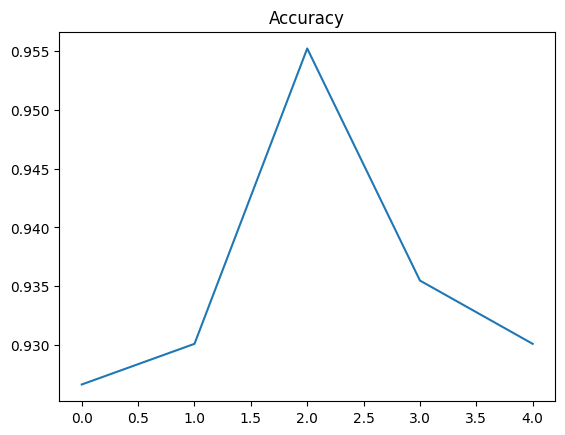

In [13]:
# Trying to plot the validation loss vas training loss to check if the model is overfitting or not . Didnt go well as expected. as evaluation loss has more datapoints and validation loss has only 5 
plt.plot(val_loss_per_fold,label="validation loss")
plt.plot(average_loss,label="training loss")
plt.title("Loss")
plt.legend()
plt.show()


#Potting the accuracy per fold to see how the models accuracy is changing over time
plt.plot(accuracy_per_fold)
plt.title("Accuracy")

Normalized Confusion Matrix:
            Astronomy  Psychology  Sociology
Astronomy    0.998889    0.000000   0.001111
Psychology   0.000000    0.920771   0.079229
Sociology    0.001045    0.108673   0.890282


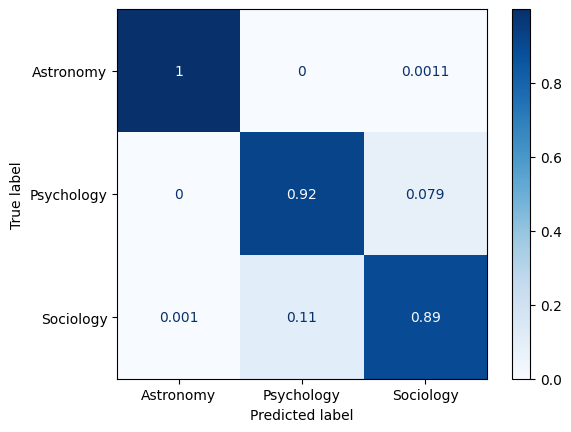

In [14]:
# Normalizing the accumulated confusion matrix
normalized_cm = cumulative_cm.astype('float') / cumulative_cm.sum(axis=1)[:, np.newaxis]
classes = ["Astronomy", "Psychology", "Sociology"]

# Printing the confusion matrix 
print("Normalized Confusion Matrix:")
print(pd.DataFrame(normalized_cm, index=classes, columns=classes))

# Visualizing the confusion matric with confusion matrix disply from sklearn
ConfusionMatrixDisplay(confusion_matrix=normalized_cm, display_labels=classes).plot(cmap="Blues")


In [15]:
# Saving the model and tokenizer 
model.save_pretrained('./bert_Abstract_classifier_model_with_KFOLD_trainer_api')
tokenizer.save_pretrained('./bert_Abstract_classifier_model_with_KFOLD_trainer_api')

('./bert_Abstract_classifier_model_with_KFOLD_trainer_api/tokenizer_config.json',
 './bert_Abstract_classifier_model_with_KFOLD_trainer_api/special_tokens_map.json',
 './bert_Abstract_classifier_model_with_KFOLD_trainer_api/vocab.txt',
 './bert_Abstract_classifier_model_with_KFOLD_trainer_api/added_tokens.json')

End of code